In [1]:
import os
from zipfile import ZipFile
import matplotlib  # Used to set default paremeters
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import statsmodels.api as sm  # statistical modelling package
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt, het_breuschpagan
from matplotlib import rcParams  # Used to set default paremeters
from scipy.spatial.distance import mahalanobis
from scipy import stats
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    LabelBinarizer,
    MinMaxScaler,
)

import xgboost as xgb
%matplotlib inline

/Users/albertovidalrodriguez-bobada/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sns.set_theme(style="darkgrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize


In [3]:
dataset_info = !kaggle datasets files thedevastator/uncovering-factors-that-affect-used-car-prices
dataset_name =  dataset_info[-1].split()[0]


path_data = os.path.dirname(os.getcwd()) + "/data"
path_zip = os.path.dirname(os.getcwd()) + "/data/uncovering-factors-that-affect-used-car-prices.zip"
path_file = os.path.dirname(os.getcwd()) + "/data/" + dataset_name

# if data is already donwloaded, print a statement to remind me
if os.path.exists(path_file):
    print("Data has already been downloaded")
# otherwise, download the data
else:
    # download data using kaggle API
    !kaggle datasets download -d thedevastator/uncovering-factors-that-affect-used-car-prices -p ../data

    # extract files in .zip folder
    with ZipFile(path_zip) as zObject:
        zObject.extractall(path=path_data)

    # delete .zip folder
    if os.path.exists(path_zip):
        os.remove(path_zip)
    else:
        print(".zip file already deleted")

Data has already been downloaded


# EDA and Feature Engineering
## Data understanding

In [4]:
data = pd.read_csv("data/autos.csv", index_col=0)

# Only interested in German cars
data = data.loc[
    (data["brand"] == "bmw")
    | (data["brand"] == "audi")
    | (data["brand"] == "volkswagen")
    | (data["brand"] == "mercedes_benz")
    | (data["brand"] == "opel"),
    :
].reset_index(drop=True)

data.head(7)


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
3,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,privat,Angebot,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
4,2016-03-21 18:54:38,VW_Derby_Bj_80__Scheunenfund,privat,Angebot,0,test,limousine,1980,manuell,50,andere,40000,7,benzin,volkswagen,nein,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
5,2016-03-17 10:53:50,VW_Golf_4_5_tuerig_zu_verkaufen_mit_Anhaengerk...,privat,Angebot,999,test,kleinwagen,1998,manuell,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
6,2016-04-07 10:06:22,Volkswagen_Passat_Variant_2.0_TDI_Comfortline,privat,Angebot,2799,control,kombi,2005,manuell,140,passat,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00,0,57290,2016-04-07 10:25:17


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228232 entries, 0 to 228231
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          228232 non-null  object
 1   name                 228232 non-null  object
 2   seller               228232 non-null  object
 3   offerType            228232 non-null  object
 4   price                228232 non-null  int64 
 5   abtest               228232 non-null  object
 6   vehicleType          205606 non-null  object
 7   yearOfRegistration   228232 non-null  int64 
 8   gearbox              216993 non-null  object
 9   powerPS              228232 non-null  int64 
 10  model                218291 non-null  object
 11  kilometer            228232 non-null  int64 
 12  monthOfRegistration  228232 non-null  int64 
 13  fuelType             208642 non-null  object
 14  brand                228232 non-null  object
 15  notRepairedDamage    184016 non-nu

In [6]:
data.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,2.282320e+05,228232.000000,228232.000000,228232.000000,228232.000000,228232.0,228232.000000
mean,1.321101e+04,2004.057389,125.857220,129860.339479,5.789679,0.0,51318.138876
std,7.648302e+05,78.503991,203.981543,37742.381405,3.724106,0.0,25911.301362
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1.300000e+03,1999.000000,75.000000,125000.000000,3.000000,0.0,30880.000000
50%,3.450000e+03,2003.000000,116.000000,150000.000000,6.000000,0.0,49744.000000
75%,8.450000e+03,2008.000000,163.000000,150000.000000,9.000000,0.0,72488.000000
max,1.000000e+08,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


## Data preparation

The first step in the data preparation process is to remove duplicates

In [7]:

data.drop_duplicates(
    subset=[
        "name",
        "price",
        "yearOfRegistration",
        "gearbox",
        "kilometer",
        "fuelType",
        "monthOfRegistration",
        "dateCreated",
        "postalCode",
        "lastSeen",
    ],
    ignore_index=True,
    inplace=True
)

The next step is to drop irrelevant features. I will first capture the year when the data was added. In the future, I would like to add more datapoints and it would be great to keep track of the year when they were all added.

In [8]:
data["yearCreated"] = pd.to_datetime(data["dateCreated"]).dt.year

data.drop(
    [
        "name",
        "seller",
        "offerType",
        "dateCrawled",
        "abtest",
        "dateCreated",
        "notRepairedDamage",
        "nrOfPictures",
        "postalCode",
        "lastSeen",
        "monthOfRegistration",
        "yearCreated"
    ],
    axis=1,
    inplace=True,
)

data.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand
0,480,NaN,1993,manuell,0,golf,150000,benzin,volkswagen
1,18300,coupe,2011,manuell,190,NaN,125000,diesel,audi
2,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen
3,650,limousine,1995,manuell,102,3er,150000,benzin,bmw
4,0,limousine,1980,manuell,50,andere,40000,benzin,volkswagen


After removing duplicates, we need to deal with `NaN` values.

In [9]:
data.isna().sum()

price                     0
vehicleType           22626
yearOfRegistration        0
gearbox               11239
powerPS                   0
model                  9941
kilometer                 0
fuelType              19590
brand                     0
dtype: int64

In [10]:
data.dropna(axis=0, subset=["gearbox", "fuelType"], inplace=True)
data.reset_index(drop=True, inplace=True)
data.isna().sum()

price                     0
vehicleType           10621
yearOfRegistration        0
gearbox                   0
powerPS                   0
model                  5510
kilometer                 0
fuelType                  0
brand                     0
dtype: int64

Since the dataset contains some German words, I will replace them using the equivalent English words.

In [11]:
data["gearbox"].replace({"manuell": "Manual", "automatik": "Automatic"}, inplace=True)
data["fuelType"].replace({"benzin": "Petrol", "diesel": "Diesel"}, inplace=True)
data["model"].replace({"andere": "unknown"}, inplace=True)
data["vehicleType"].replace({"andere": "unknown"}, inplace=True)

Some of the columns include the word "andere", whiche means "unknown" in English. In the next sections I will perform feature engineering and create new features based on the car model. Therefore, unknown car models need to removed.

In [12]:

data = data[data["model"] != "unknown"].reset_index(drop=True)

In [13]:
data = data.loc[
    (data["fuelType"] == "Petrol") | (data["fuelType"] == "Diesel"), :
].reset_index(drop=True)

### Feature Engineering

In [14]:
data["powerHP"] = data["powerPS"] * 0.98632
data.drop(columns=["powerPS"], inplace=True)

The main difference with respect to the other notebook is that I encode the brand in this one. 

In [15]:
transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), ["gearbox", "fuelType", "brand"]),
    remainder="drop",
)

transformed = transformer.fit_transform(data)
data_transformed = pd.DataFrame(
    transformed, columns=transformer.get_feature_names_out()
)

transformed_cols = data_transformed.columns.tolist()
new_transformed_cols = [
    name.replace("onehotencoder__", "") for name in transformed_cols
]
data_transformed.columns = new_transformed_cols


data["gearbox"] = data_transformed["gearbox_Manual"]
data["fuelType"] = data_transformed["fuelType_Petrol"]


data["gearbox"] = data["gearbox"].astype(int)
data["fuelType"] = data["fuelType"].astype(int)

data = pd.concat([data, data_transformed.loc[:,"brand_bmw":]], axis=1)

data.head()

,price,vehicleType,yearOfRegistration,gearbox,model,kilometer,fuelType,brand,powerHP,brand_bmw,brand_mercedes_benz,brand_opel,brand_volkswagen
0,480,NaN,1993,1,golf,150000,1,volkswagen,0.00000,0.0,0.0,0.0,1.0
1,18300,coupe,2011,1,NaN,125000,0,audi,187.40080,0.0,0.0,0.0,0.0
2,1500,kleinwagen,2001,1,golf,150000,1,volkswagen,73.97400,0.0,0.0,0.0,1.0
3,650,limousine,1995,1,3er,150000,1,bmw,100.60464,1.0,0.0,0.0,0.0
4,2799,kombi,2005,1,passat,150000,0,volkswagen,138.08480,0.0,0.0,0.0,1.0


## Feature understanding and outliers

Since it's the same dataset as in `car price prediction.ipynb`, this notebook doesn't include visualisations of individual features

### Price


In [16]:
data = data[(data["price"] > 300) & (data["price"] < 60000)].reset_index(drop=True)

### Power

In [17]:
upper_threshold = 250
lower_threshold = 40

# data = data.query("powerHP < @upper_threshold").reset_index(drop=True)
mask = ((data["powerHP"] < lower_threshold) | (data["powerHP"] > upper_threshold))
data = data[~mask].reset_index(drop=True)

### Year of registration

In [18]:
data = data[
    (data["yearOfRegistration"] > 1975) & (data["yearOfRegistration"] < 2016)
].reset_index(drop=True)

In [19]:
data_mal = data.drop(["brand"], axis=1).copy()
data_mal = data_mal.drop(["vehicleType", "model"], axis=1)

ss = StandardScaler()
data_mal_scaled = pd.DataFrame(ss.fit_transform(data_mal))
data_mal_scaled.columns = ss.get_feature_names_out().tolist()
data_mal_scaled.head()


,price,yearOfRegistration,gearbox,kilometer,fuelType,powerHP,brand_bmw,brand_mercedes_benz,brand_opel,brand_volkswagen
0,1.730271,1.348947,0.582146,-0.124871,-1.221727,1.257069,-0.474756,-0.409992,-0.441992,-0.746978
1,-0.745286,-0.350442,0.582146,0.559004,0.818514,-1.149358,-0.474756,-0.409992,-0.441992,1.338728
2,-0.870538,-1.370076,0.582146,0.559004,0.818514,-0.584370,2.106347,-0.409992,-0.441992,-0.746978
3,-0.553873,0.329314,0.582146,0.559004,-1.221727,0.210797,-0.474756,-0.409992,-0.441992,1.338728
4,-0.819111,-1.370076,0.582146,0.559004,0.818514,-0.312340,-0.474756,-0.409992,-0.441992,1.338728


## Multivariate outlier detection

Something I found in the first runs of this notebook is that worst performing points after creating the regression models aren't "traditional outliers". Since I already went through outlier detection and removal of individual features, these datapoints aren't outliers in a single category, but it's the combination of values, such as a very high kilometer value. yet a very expensive car, that causes the model to underperform. 

As a result, I've implemented the Mahalanobis distance to find multivarite outliers:


In [20]:
cov = data_mal_scaled.cov()
mu = data_mal_scaled.mean()

data["price"] = np.log(data["price"])


# Calculate the inverse of the covariance matrix
cov_inv = np.linalg.inv(cov)

# Calculate the Mahalanobis distance for each observation
distances = [
    mahalanobis(data_mal_scaled.iloc[i, :], mu, cov_inv) for i in range(len(data_mal_scaled))
]

# Set a threshold for the distances
threshold = np.percentile(distances, 90)

# Identify the outliers
outliers = [i for i in range(len(data_mal_scaled)) if distances[i] > threshold]

data = data.drop(outliers, axis=0).reset_index(drop=True)

## Feature Relationships

It's worth noting the difference between this plot and the one in the other notebook. It shows the impact of removing the multivariate outliers, such as removing old expensive cars or new cheap cars

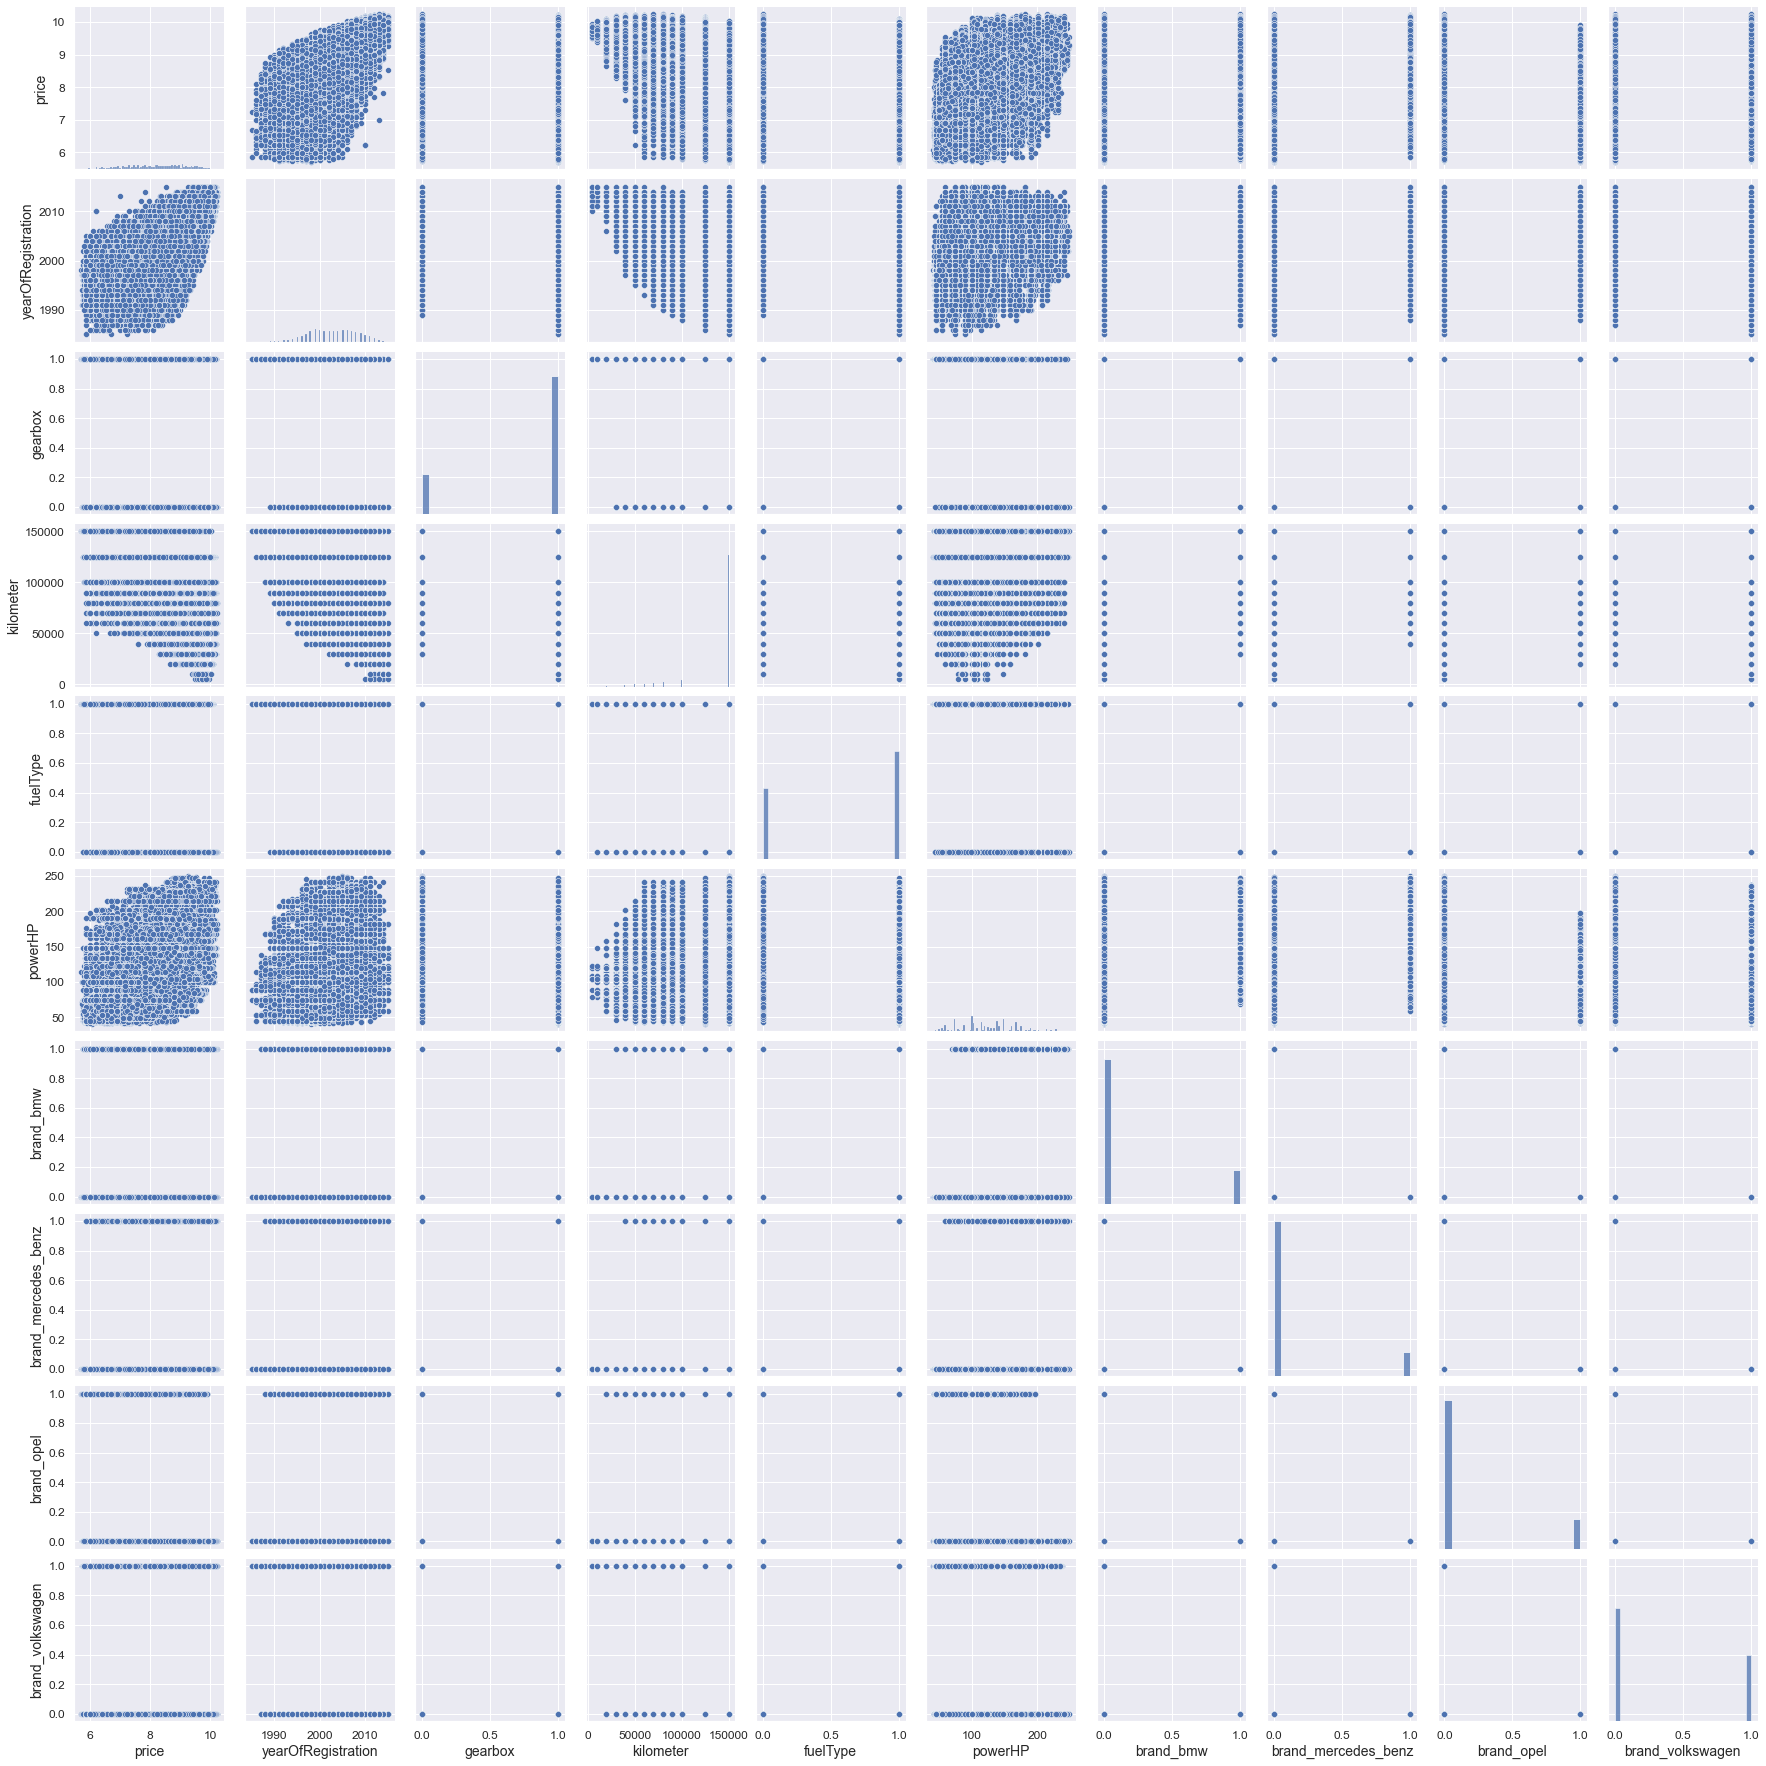

In [21]:

sns.pairplot(data=data)

# Regression - No difference between brands

In [22]:
TARGET = "price"
FEATURES = [
    column for column in data.columns if data[column].dtype != "O" and column != TARGET
]

X_data = data[FEATURES]
y_data = data[TARGET]

## Linear regression

In [23]:
def plot_residuals_analysis(X_test, y_test, model):
    # Generate predictions and residuals
    predictions = model.predict(X_test)
    residuals = y_test - predictions
    
    # Calculate min and max values for plot
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())

    # Print RMSE of residuals
    print(f"RMSE of residuals: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}")

    # Test for homocedasticity
    # Use het_breuschpagan to test for heteroscedasticity
    lm, p, fvalue, fpvalue = het_breuschpagan(residuals, X_test)
    # Print results
    print("----HETEROCEDASTICITY----")
    print(f"Breusch-Pagan test: p-value={p:.3f}, f-value={fvalue:.2f}, fp-value={fpvalue:.3f}")
    
    # Use het_goldfeldquandt to test for heterocedasticity
    test_stat, p_value, _ = het_goldfeldquandt(residuals, X_test)
    # Print results
    print(f"Goldfeld-Quandt test: p-value={p_value:.3f}, test stat={test_stat:.2f}")

    # Test for normality using kstest
    test_stat, p_value = stats.kstest(residuals, "norm")
    # Print results
    print("----NORMALITY----")
    print(f"Skewness of residuals: {stats.skew(residuals)}")
    print(f"Kurtosis of residuals: {stats.kurtosis(residuals)}")
    print(f"Kolmogorov-Smirnov test: p-value={p_value:.3f}, test stat={test_stat:.2f}")

    # Plot results using subplots
    fig, axes = plt.subplots(1, 4, figsize=(21, 6))

    # Plot true values vs. predictions using scatterplot
    sns.scatterplot(x=y_test, y=predictions, ax=axes[0], alpha=0.15)
    axes[0].set_title("True values vs predictions")
    # Add line to indicate perfect prediction
    axes[0].plot([min_val, max_val], [min_val, max_val], c="r", lw=3)
    axes[0].set_xlabel("True values")
    axes[0].set_ylabel("Predictions")

    # Plot residuals using scatterplot
    sns.scatterplot(x=y_test, y=residuals, ax=axes[1], alpha=0.15)
    axes[1].set_title("Residuals")
    # Add line to indicate zero residual
    axes[1].plot([y_test.min(), y_test.max()], [0, 0], c="r", lw=3)
    axes[1].set_xlabel("True values")
    axes[1].set_ylabel("Residuals")

    # Plot QQ plot to test for normality
    qqplot(residuals, fit=True, line="45", ax=axes[2])
    axes[2].set_title("QQ plot")
    # Generate a normal distribution using mean and std from residuals
    mean = np.mean(residuals)
    std = np.std(residuals)
    norm_dist = stats.norm(loc=mean, scale=std)
    x_vals = np.linspace(mean - 4 * std, mean + 4 * std, 1000)
    # Calculate multiplier to overlay normal dsitribution on top of residual histogram
    counts, _ = np.histogram(residuals, bins=50)
    multiplier = max(counts) / max(norm_dist.pdf(x_vals))

    # Plot histogram of residuals
    sns.histplot(x=residuals, ax=axes[3], bins=50, kde=True)
    # Plot normal distribution on top of histogram
    axes[3].plot(x_vals, norm_dist.pdf(x_vals) * multiplier, color="red")
    axes[3].set_title("Histogram of residuals")
    axes[3].set_xlabel("Residuals")


To make the anslysis quicker, I will remove the grid searcha for the linear regression and focus on the analysis of the results:

RMSE of residuals: 0.41
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=1197.29, fp-value=0.000
Goldfeld-Quandt test: p-value=0.659, test stat=0.99
----NORMALITY----
Skewness of residuals: -0.15266862293643269
Kurtosis of residuals: 1.99254398578584
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.22


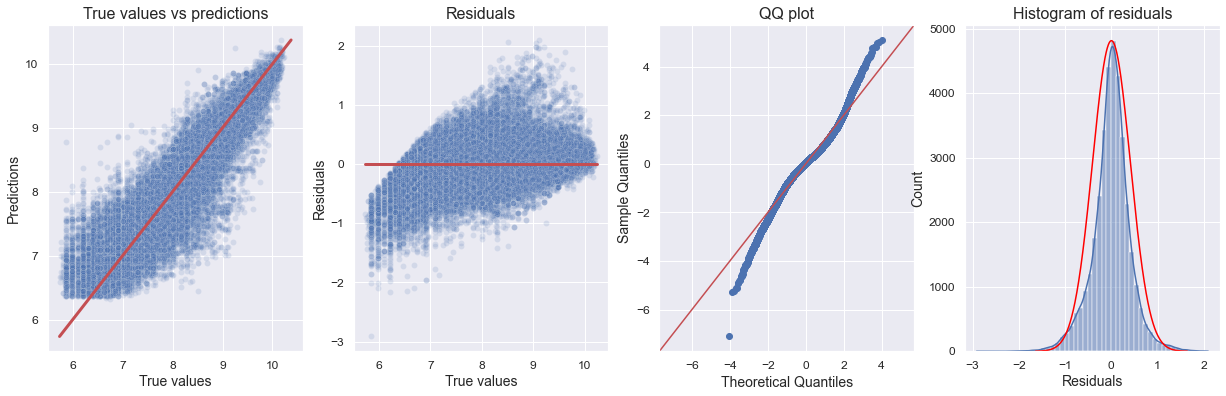

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42
)

num_splits = 5
sk_fold = KFold(n_splits=num_splits, random_state=42, shuffle=True)

# Define pipeline steps
steps = [
    ("scaler", MinMaxScaler()),
    ("pol_features", PolynomialFeatures(5)),
    ("model", LinearRegression()),
]

# Create pipeline object
pipeline = Pipeline(steps=steps)

# search_lr.fit(X_train, y_train)
pipeline.fit(X_train, y_train);

plot_residuals_analysis(X_test, y_test, pipeline)

The next step is to identify the worst performing points:

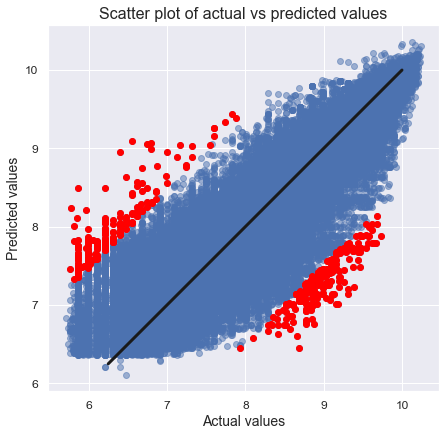

In [25]:
X_vals = X_train
y_vals = y_train

predictions = pipeline. predict(X_vals)
residuals = y_vals-predictions

# calculate absolute residuals
abs_residuals = np.abs(residuals)

# sort absolute residuals in descending order
sorted_abs_residuals = abs_residuals.sort_values(ascending=False)

# calculate IQR
q1, q3 = np.percentile(sorted_abs_residuals, [3,97])
iqr = q3 - q1

# identify threshold for outliers
threshold = 1.5 * iqr

# identify outliers
# outlier_indices = np.where(abs_residuals > threshold)[0]
logic_ind = abs_residuals > threshold

num_ind = (logic_ind[logic_ind==True]).index

plt.figure(figsize=(7,7))
# plot scatter plot with outliers highlighted
plt.scatter(y_vals, predictions, alpha=0.5)
plt.plot([6.25, 10],[6.25, 10], c="k", lw=3)
plt.scatter(y_vals[logic_ind], predictions[logic_ind], color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of actual vs predicted values')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

# map outliers back to original dataset
outliers = data.iloc[num_ind]



## XGBRegressor

/Users/albertovidalrodriguez-bobada/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/albertovidalrodriguez-bobada/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/albertovidalrodriguez-bobada/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/albertovidalrodriguez-bobada/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWar

RMSE of residuals: 0.37
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=3731.89, fp-value=0.000
Goldfeld-Quandt test: p-value=0.010, test stat=1.02
----NORMALITY----
Skewness of residuals: -0.3155372923689551
Kurtosis of residuals: 1.9037691177879328
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.24


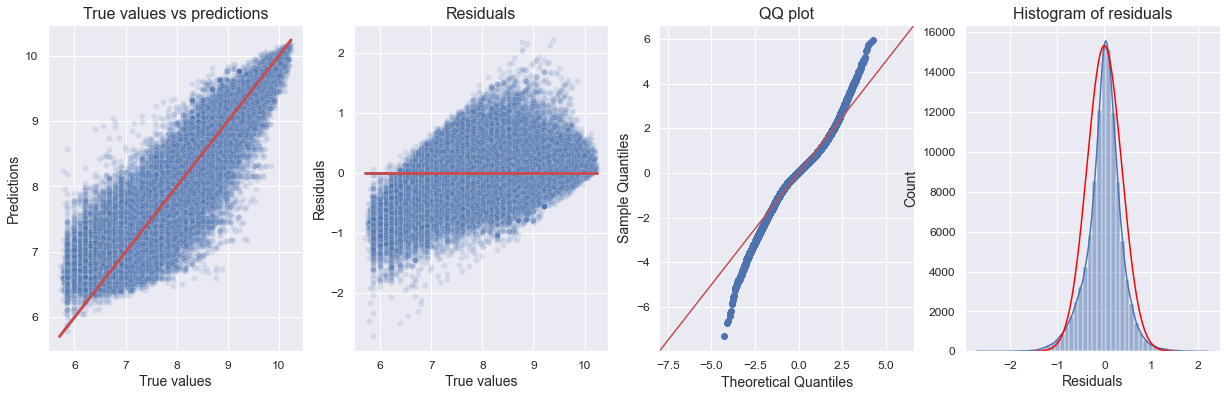

In [26]:
# Define pipeline steps
steps = [
    ("scaler", MinMaxScaler()),
    ("model", xgb.XGBRegressor()),
]

# Create pipeline object
pipeline = Pipeline(steps=steps)

# param_grid = {"pol_features__degree": range(1, 3)}
param_grid = {"model__max_depth": [4, 7, 9], "model__n_estimators": [100, 200]}

search_xgb = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=["neg_root_mean_squared_error", "r2"],
    refit="neg_root_mean_squared_error",
    cv=sk_fold,
    n_jobs=-1,
    verbose=0,
)

search_xgb.fit(X_train, y_train);

plot_residuals_analysis(X_train, y_train, search_xgb) 

## Decision Tree regressor

RMSE of residuals: 0.40
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=1050.87, fp-value=0.000
Goldfeld-Quandt test: p-value=0.268, test stat=1.01
----NORMALITY----
Skewness of residuals: -0.2173075718131745
Kurtosis of residuals: 2.506553730198349
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.23


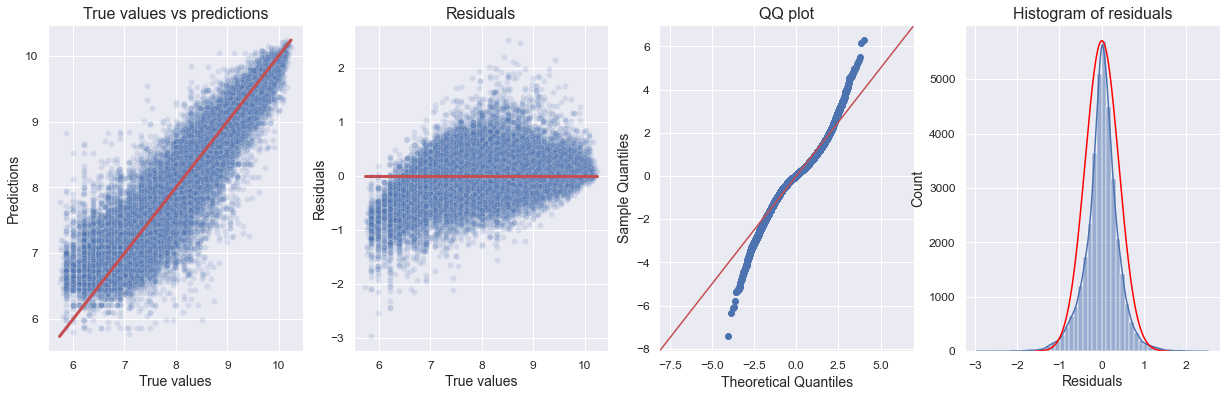

In [27]:
# Define pipeline steps
steps = [
    ("scaler", MinMaxScaler()),
    # ("pol_features", PolynomialFeatures()),
    ("model", DecisionTreeRegressor(random_state=42)),
]

# Create pipeline object
pipeline = Pipeline(steps=steps)

# param_grid = {"pol_features__degree": range(1, 5)}
param_grid ={"model__max_depth": [5, None]}

search_dt = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=["neg_root_mean_squared_error", "r2"],
    refit="neg_root_mean_squared_error",
    cv=sk_fold,
    n_jobs=-1,
    verbose=0,
)

search_dt.fit(X_train, y_train);

plot_residuals_analysis(X_test, y_test, search_dt)

## SVRegression

RMSE of residuals: 0.42
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=1122.34, fp-value=0.000
Goldfeld-Quandt test: p-value=0.294, test stat=1.01
----NORMALITY----
Skewness of residuals: -0.031476376156325835
Kurtosis of residuals: 2.313239094343797
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.23


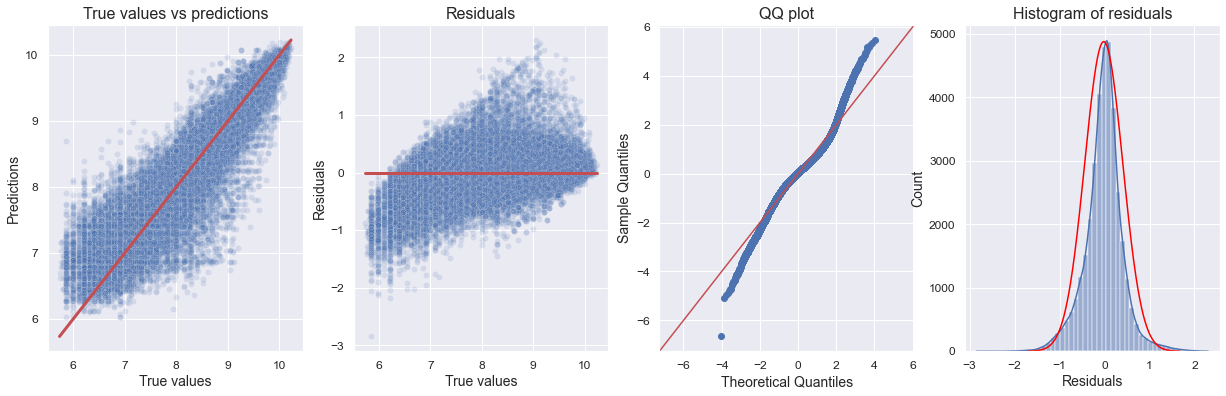

In [28]:
from sklearn.svm import SVR

# Define pipeline steps
steps = [
    ("scaler", MinMaxScaler()),
    # ("pol_features", PolynomialFeatures()),
    ("model", SVR(kernel='rbf', C=1.0)),
]

# Create pipeline object
pipeline = Pipeline(steps=steps)

svr = pipeline.fit(X_test, y_test)

plot_residuals_analysis(X_test, y_test, svr)

# Regression - one model per brand

## Linear Regression

In [29]:
brands = data["brand"].unique().tolist()

models = {}
models_list = []
X_test_list = []
y_test_list = []


for i, brand in enumerate(brands):
    data_brand = data[data["brand"] == brand]

    X_data = data_brand[FEATURES]
    y_data = data_brand[TARGET]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.25, random_state=42
    )
    X_test_list.append(X_test)
    y_test_list.append(y_test)

    num_splits = 4
    sk_fold = KFold(n_splits=num_splits, random_state=42, shuffle=True)

    # Define pipeline steps
    steps = [
        ("scaler", MinMaxScaler()),
        ("pol_features", PolynomialFeatures()),
        # ("model", LinearRegression()),
        ("model", Ridge())
    ]

    # Create pipeline object
    pipeline = Pipeline(steps=steps)
    param_grid = {"pol_features__degree": range(1, 4)}
    param_grid = {"pol_features__degree": range(1, 5), "model__alpha": [1,2.5,5]}

    search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=["neg_root_mean_squared_error", "r2"],
        refit="neg_root_mean_squared_error",
        cv=sk_fold,
        n_jobs=-1,
        verbose=0,
    )

    search.fit(X_train, y_train)

    models[f"{brand}_model"] = search
    models_list.append(search)

/Users/albertovidalrodriguez-bobada/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/albertovidalrodriguez-bobada/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/albertovidalrodriguez-bobada/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/albertovidalrodriguez-bobada/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A wo

RMSE of residuals: 0.38
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=285.64, fp-value=0.000
Goldfeld-Quandt test: p-value=0.882, test stat=0.95
----NORMALITY----
Skewness of residuals: -0.5500603812663276
Kurtosis of residuals: 2.377924379298425
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.24
RMSE of residuals: 0.44
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=362.57, fp-value=0.000
Goldfeld-Quandt test: p-value=0.999, test stat=0.93
----NORMALITY----
Skewness of residuals: 0.06169362863729293
Kurtosis of residuals: 1.78544280380006
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.22
RMSE of residuals: 0.42
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=228.89, fp-value=0.000
Goldfeld-Quandt test: p-value=0.926, test stat=0.95
----NORMALITY----
Skewness of residuals: -0.1450952204604771
Kurtosis of residuals: 1.8141894127995464
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.23
RMSE of residuals: 0.43
-

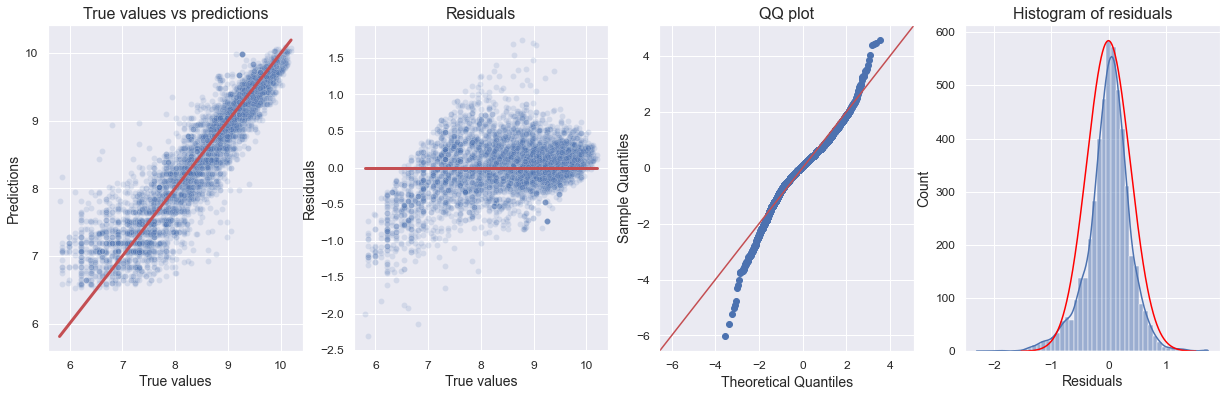

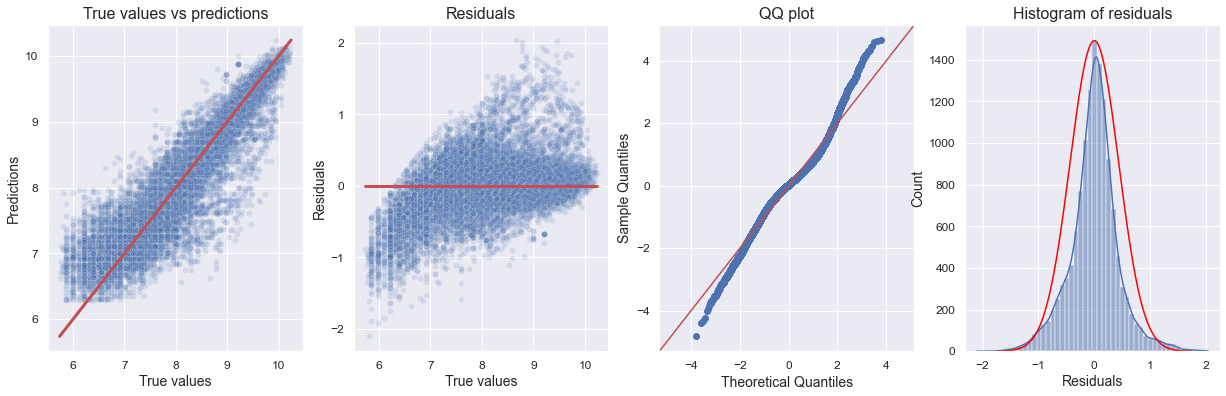

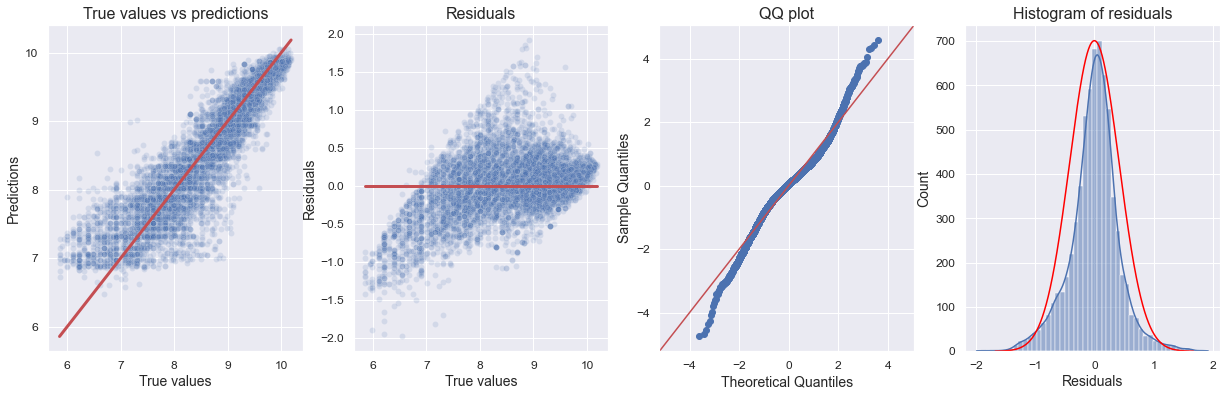

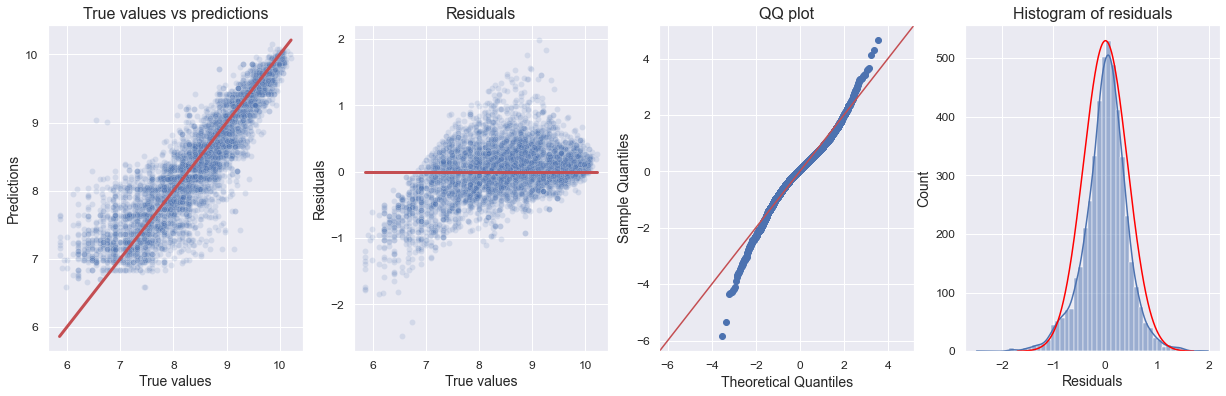

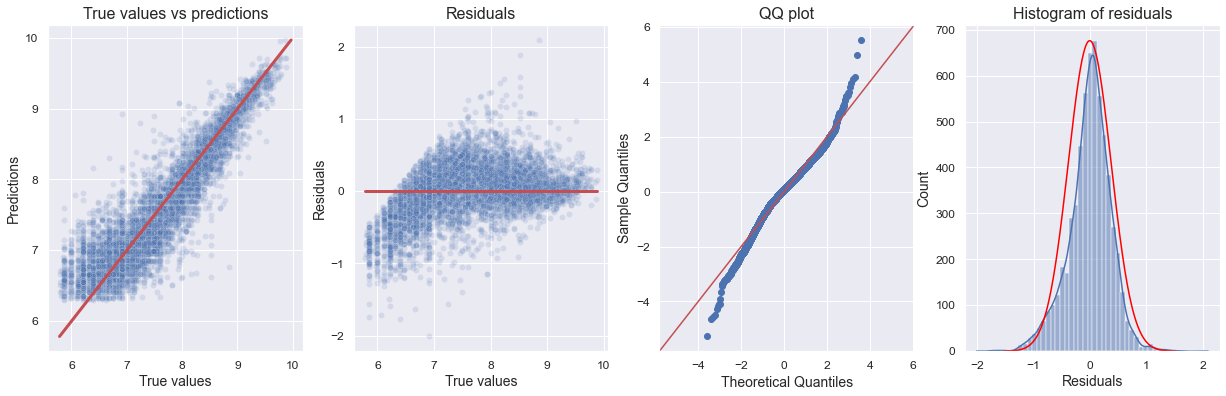

In [30]:
for i, (X_test, y_test, model) in enumerate(zip(X_test_list, y_test_list, models_list)):
    plot_residuals_analysis(X_test, y_test, model)

The plots above show that creating one model per brand doesn't improve the predictions, in fact, they are worse than having an overall model, especially for lower car prices, which the model overpredicts.

This shows that the model is underfitting and it cannot capture the complexity of the data. The fact that Decision Trees, XGBoost and Support Vector Regressor with rbf function shows that the features used for the model aren't enough to predict the car price. I could try adding other features, but in my opinion, they are less informative than the ones I've used. Also, my idea is to create a model that can be scaled and used other datasets. 